# Libs import

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import resample

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

# Here you can take look at the Collages dataset

In [3]:
tags_clarifai_final = pd.read_excel('nmf_tailoring/tags_clarifai_final.xlsx', index_col='imageID')
user_info_Approved_Collages = pd.read_csv('nmf_tailoring/user_info_Approved_Collages.csv', index_col='collage_id')
user_info_Approved_Collages = user_info_Approved_Collages[user_info_Approved_Collages.imageID!='None']

# Loading TF-IDF and Embeddings (precomputed, preprocessing in other notebooks)

In [25]:
with open('nmf_tailoring/tags_vectors.pickle', 'rb') as f:
    tags_vectors = pickle.load(f)
with open('nmf_tailoring/TfIdf_Sparse.pickle', 'rb') as f:
    TFIDF = pickle.load(f)
all_tags = sorted(list(tags_vectors.keys()))

# Class NMF_model(self, 
TFIDF - TF-IDF matrix,
tags_vectors - ebmeddings matrix,
all_tags - vocabulary,
n_comp_range - the range in which the number of topics is going to change, by default np.arange(10, 30, 10), bootstrapping -  the number of resamplings for variance estimates, default 10)

# methods:

    
## fit_components_bootstrap(self, n_comp_range):
        In a certain range of topic quantities trains and saves the topic elicitation model on bootstrapped samples (and also saves the samples) for further metrics statistical variance estimation.
        (Since all is saved, other computational and visualizational methods can be applied to any other metric without additional training.)
               
                    
## compute_model_quality(self, model, n_top_words=15):

  For a given topic elicitation model with topics $T$, the following method considers each of the topics $t\in T$ as a set of $n\_top\_words=n_{tw}$ words such that $\forall w\in t$  the probability to occur in a topic $t$ is $\mathbf{P}(w|t)$, and the method computes a CDR metric (Cosine Distance Ratio) for the model with topics $T$ defined as follows:

\\[
Cosine\ Distance\ Ratio (T)= \frac{\frac{1}{\|T\|}\sum_{t\in T}Internal\ Topic\ Similarity(t)}
{\frac1{T(T-1)} \sum_{t_1\in T, t_2\in T, t_1\ne t_2}External\ Topic\ Similarity(t_1, t_2)},
\\]

  where

\\[
Internal\ Topic\ Similarity(t)=\frac{\sum_{w_1, w_2 \in t, w_1\ne w_2} \mathbf{P}(w_1|t)\mathbf{P}(w_2|t)\langle w_1, w_2\rangle}{\sum_{w_1, w_2\in t, w_1 \ne w_2}\mathbf{P}(w_1|t)\mathbf{P}(w_2|t)}
\\]

and 

\\[
External\ Topic\ Similarity(t_1, t_2) = \frac
{\sum_{w_1\in t_1, w_2\in t_2, w_1\ne w_2}\mathbf{P}(w_1|t_1)\mathbf{P}(w_2|t_2)\langle w_1, w_2\rangle}{\sum_{w_1\in t_1, w_2\in t_2, w_1\ne w_2}\mathbf{P}(w_1|t_1)\mathbf{P}(w_2|t_2)}
\\]
        
are expected cosine similarities of different words, within a singular topic $t$, and across two different topics $t_1$ and $t_2$, respectively, and $\langle\cdot,\cdot\rangle$ is cosine similarity; for the embedding algorithm we are using $\|w\|=1\forall w$ known to embedding, and hence $\langle\cdot,\cdot\rangle:\mathbf{R}^{512}\times\mathbf{R}^{512}\rightarrow\left[0;1\right]$.

The higher the metric, the more homogemeous in a cosine similarity sence are different words on average within a singular group, in comparison with similarity across different groups.

In theory it may take values in $CSR(T, n_{tw})\in\left[0, +\infty\right)$, whereas the expected values and the values in in practice are bigger than $1$ corresponding to a random topic elicitation $CSR(T, n_{tw})>1$.

## compute_model_quality_bootstrap(self, n_top_words=15):
        Saves scatter visualization data for bootstrapped samples models qualities, their means, and the unbiased variance estimates. Returns means and variances.
        
## plot_model_quality_bootstrap(self, n_top_words=15, scatter=False):
        Reads bootstrapping output data and plots $CSR$ metric in a number of topics $n_components$, also plots 95% confidence intervals for the unbiased sample variance estimates for the plotted munbers.
        If $scatter=True$ plots metrics for the bootstrap model samples.
    
## closest_tag(self, topic):
        For a given embedding vector returns the closest tag in the embedding space. Can be used to choose a name for a topic.
    
## save_topics_bootstrap(self, n_top_words=15, save_to_xlsx=False):
        Reads the models trained on bootstrapped samples and saves tables with topics for these models.

In [35]:
class NMF_model:
    
    def __init__(self, TFIDF, tags_vectors, all_tags, n_comp_range=np.arange(10, 30, 10), bootstrapping = 10):
        self.TFIDF = TFIDF
        self.n_comp_range = n_comp_range
        self.bootstrapping = bootstrapping
        self.tags_vectors = tags_vectors
        self.all_tags = all_tags
        self.embedding_array = np.array([self.tags_vectors[i] for i in self.all_tags])
        self.words_similarities = self.embedding_array@(self.embedding_array.T)
        self.words_coincidence = np.eye(len(self.embedding_array))
        
    def fit_components_bootstrap(self, n_comp_range):
        self.n_comp_range = n_comp_range
        for n_components in tqdm(n_comp_range):
            for i_btstrp in tqdm(range(self.bootstrapping)):
                resampled_tfidf = resample(self.TFIDF)
                with open('nmf_tailoring/resampled_tfidf_{}_{}.pickle'.format(n_components, i_btstrp), 'wb') as f:
                    pickle.dump(resampled_tfidf, f)
                nmf = NMF(n_components=n_components, beta_loss='kullback-leibler', 
                          solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5)
                nmf.fit(self.TFIDF)
                with open('nmf_tailoring/nmf_{}_{}.pickle'.format(n_components, i_btstrp), 'wb') as f:
                    pickle.dump(nmf, f)
                    
    def compute_model_quality(self, model, n_top_words=15):
        internal_topics_similarity = []
        external_topics_similarity = []
        topics_top_words_probabilities = []
        pass
        topics_top_words_idx = []
        for i, topic_top_words_probabilities in enumerate(model.components_):
            topics_top_words_idx.append(topic_top_words_probabilities.argsort()[:-n_top_words - 1:-1])
            topic_top_words_probabilities = topic_top_words_probabilities[topics_top_words_idx[-1]]
            topic_top_words_probabilities /= np.sum(topic_top_words_probabilities)
            topics_top_words_probabilities.append(topic_top_words_probabilities)
        topics_top_words_probabilities = np.array(topics_top_words_probabilities)
        topics_top_words_idx = np.array(topics_top_words_idx)
        for i, (topic1_probabilities, topwords1_idx) in enumerate(zip(topics_top_words_probabilities, topics_top_words_idx)):
            speedup_matrix_similarity = (topic1_probabilities@self.words_similarities[topwords1_idx]).reshape(1, -1)
            speedup_matrix_coincidence = (topic1_probabilities@self.words_coincidence[topwords1_idx]).reshape(1, -1)
            words_coincidence_term=speedup_matrix_coincidence[:, topwords1_idx]@(topic1_probabilities.T)
            num = speedup_matrix_similarity[:, topwords1_idx]@(topic1_probabilities.T)
            num = num - words_coincidence_term
            den = 1 - words_coincidence_term
            internal_topics_similarity.append(num/den)
            for (topic2_probabilities, topwords2_idx) in zip(topics_top_words_probabilities[i:], topics_top_words_idx[i:]):
                words_coincidence_term=speedup_matrix_coincidence[:, topwords2_idx]@(topic2_probabilities.T)
                num = speedup_matrix_similarity[:, topwords2_idx]@(topic2_probabilities.T)
                num = num - words_coincidence_term
                den = 1 - words_coincidence_term
                external_topics_similarity.append(num/den)
        return np.mean(internal_topics_similarity)/np.mean(external_topics_similarity)
    
    def compute_model_quality_bootstrap(self, n_top_words=15):
        metrics_means = []
        metrics_stds = []
        scatter_points=[]
        for n_components in (self.n_comp_range):
            btstrp_quality_metric = []
            for i_btstrp in (range(self.bootstrapping)):
                #with open('nmf_tailoring/resampled_tfidf_{}_{}.pickle'.format(n_components, i_btstrp), 'rb') as f:
                #    resampled_tfidf = pickle.load(f)
                with open('nmf_tailoring/nmf_{}_{}.pickle'.format(n_components, i_btstrp), 'rb') as f:
                    nmf = pickle.load(f)
                btstrp_quality_metric.append(self.compute_model_quality(nmf, n_top_words=n_top_words))
                scatter_points.append([n_components, btstrp_quality_metric[-1]])
            metrics_means.append(np.mean(btstrp_quality_metric))
            metrics_stds.append(np.std(btstrp_quality_metric)*self.bootstrapping/(self.bootstrapping-1))
            with open('nmf_tailoring/nmf_{}_metric_{}.pickle'.format(n_components, n_top_words), 'wb') as f:
                pickle.dump((metrics_means[-1], metrics_stds[-1]), f)
        scatter_points = np.array(scatter_points)
        with open('nmf_tailoring/nmf_scatter_{}.pickle'.format(n_top_words), 'wb') as f:
            pickle.dump(scatter_points, f)
        return(metrics_means, metrics_stds)
        
    def plot_model_quality_bootstrap(self, n_top_words=15, scatter=False):
        metrics_means = []
        metrics_stds = []
        for n_components in (self.n_comp_range):
            with open('nmf_tailoring/nmf_{}_metric_{}.pickle'.format(n_components, n_top_words), 'rb') as f:
                mn, st = pickle.load(f)
            metrics_means.append(mn)
            metrics_stds.append(st)
        metrics_means = np.array(metrics_means)
        metrics_stds = np.array(metrics_stds)
        plt.figure(figsize =(8, 5))
        plt.fill(np.concatenate([self.n_comp_range, self.n_comp_range[::-1]]),
        np.concatenate([metrics_means - 1.96 * metrics_stds, (metrics_means + 1.96*metrics_stds)[::-1]]),'b', alpha=.40, label='95% Conf Int')
        plt.plot(self.n_comp_range, np.array(metrics_means), 'r', label='Mean')
        if scatter:
            with open('nmf_tailoring/nmf_scatter_{}.pickle'.format(n_top_words), 'rb') as f:
                scatter_points = pickle.load(f)
            plt.scatter(scatter_points[:,0], scatter_points[:, 1], label='samples')
        plt.ylabel('Cosine Distance Ratio')
        plt.xlabel('n_topics for NMF')
        plt.legend(loc='upper left')
        plt.title(u'Embeddings-based metric:\nCosine Distance Ratio for $n\_top\_words={}$'.format(n_top_words))
        plt.show()
        return metrics_means, metrics_stds
    
    def closest_tag(self, topic):
        topic /= np.linalg.norm(topic)
        topic_expected_vector = topic@self.embedding_array
        topic_expected_vector /= np.linalg.norm(topic_expected_vector)
        similarities_w_tags = self.embedding_array@topic_expected_vector
        return all_tags[similarities_w_tags.argsort()[0]]
    
    def save_topics_bootstrap(self, n_top_words=15, save_to_xlsx=False):
        for n_components in self.n_comp_range:
            for i_btstrp in (range(self.bootstrapping)):
                with open('nmf_tailoring/nmf_{}_{}.pickle'.format(n_components, i_btstrp), 'rb') as f:
                    nmf = pickle.load(f)

                data = np.array([([self.all_tags[i] for i in topic.argsort()[:-n_top_words - 1:-1]]) for topic in nmf.components_])
                topics = pd.DataFrame(data, columns=['word_{}'.format(i) for i in range(1, n_top_words+1)], index=['topic_{}'.format(i) for i in range(1, 1+n_components)])

                if save_to_xlsx:
                    topics.to_excel('nmf_tailoring/NMF_{}_topics_{}.xlsx'.format(n_components, i_btstrp))
        
        return topics

In [30]:
nmf_model = NMF_model(TFIDF, tags_vectors, all_tags, bootstrapping=5, n_comp_range=range(10, 131, 10))
nmf_model.fit_components(nmf_model.n_comp_range)

In [33]:
for n_top_words in [7]:
    nmf_model.compute_model_quality_bootstrap(n_top_words=n_top_words)

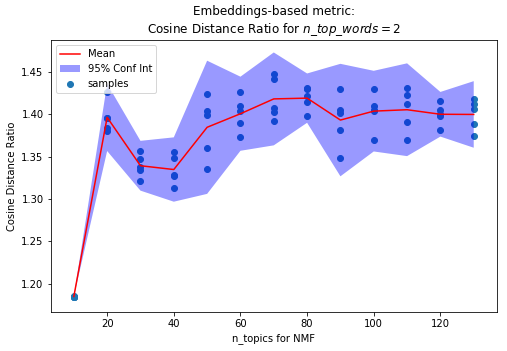

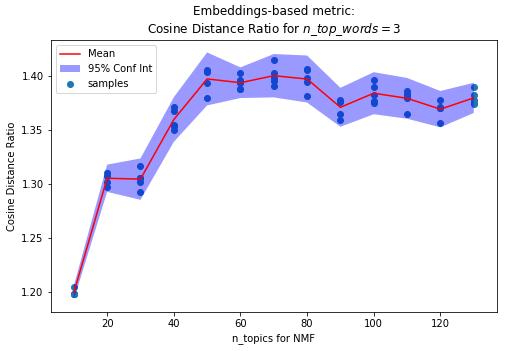

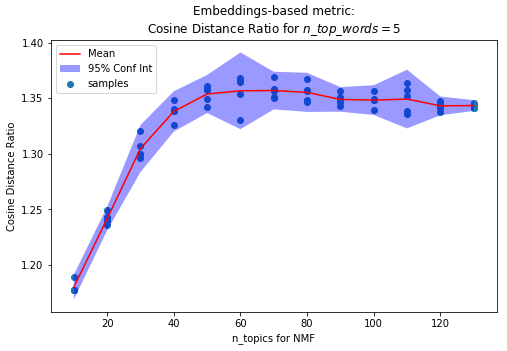

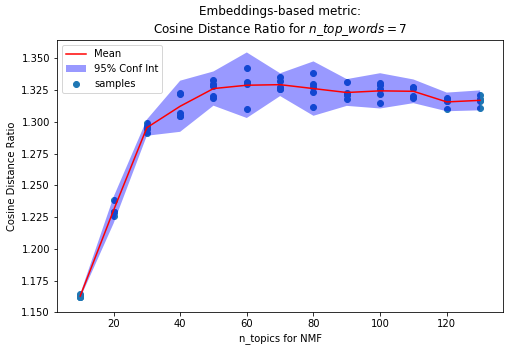

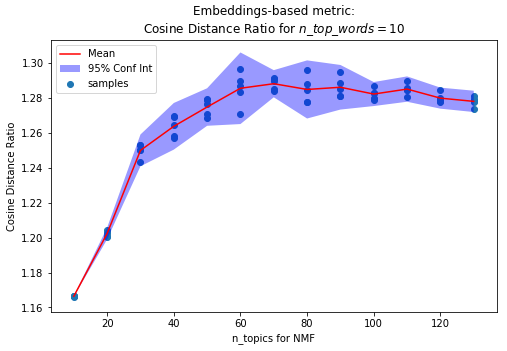

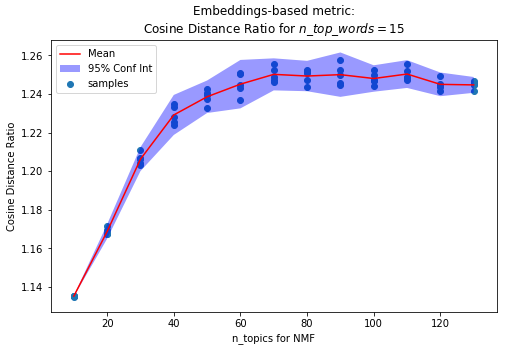

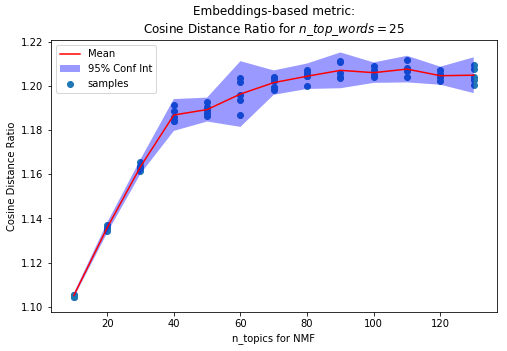

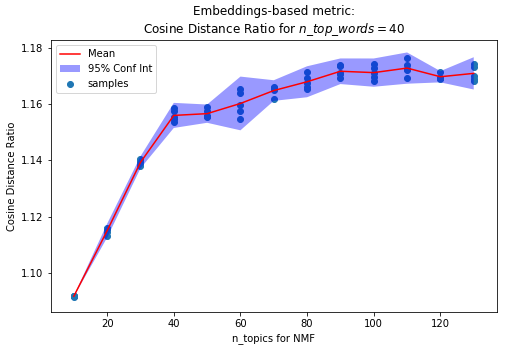

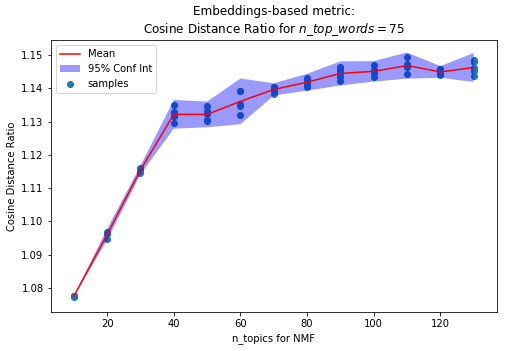

In [34]:
for n_top_words in [2, 3, 5, 7, 10, 15, 25, 40, 75]:
    #nmf_model.compute_model_quality_bootstrap(n_top_words=n_top_words)
    metrics_means, metrics_stds = nmf_model.plot_model_quality_bootstrap(n_top_words=n_top_words, scatter=True)

In [45]:
n_components=50
n_top_words=15
nmf = NMF(n_components=n_components, beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5)
nmf.fit(nmf_model.TFIDF)
with open('trained_NMF_{}.pickle'.format(n_components), 'wb') as f:
    pickle.dump(nmf, f)
data = np.array([([nmf_model.all_tags[i] for i in topic.argsort()[:-n_top_words - 1:-1]]) for topic in nmf.components_])
topics = pd.DataFrame(data, columns=['word_{}'.format(i) for i in range(1, n_top_words+1)], index=['topic_{}'.format(i) for i in range(1, 1+n_components)])
topics.to_excel('trained_NMF_{}.xlsx'.format(n_components))

In [40]:
topics

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,...,word_66,word_67,word_68,word_69,word_70,word_71,word_72,word_73,word_74,word_75
topic_1,beach,sea,ocean,sun,water,sunset,sky,dawn,landscape,fair weather,...,architecture,love,art,storm,cold,rock,growth,closeup,young,environment
topic_2,fashion,girl,woman,model,adult,portrait,wear,one,young,face,...,road,son,couple,black and white,lips,sunglasses,school,lady,laughing,baby
topic_3,health,fruit,food,nutrition,grow,healthy,leaf,delicious,juicy,confection,...,dew,coloring,dinner,pattern,field,tomato,medicine,rain,design,epicure
topic_4,urban,architecture,building,city,street,old,design,vintage,transportation system,art,...,door,traditional,iron,empty,glass items,classic,dusk,graffiti,decoration,daylight
topic_5,meal,dinner,cooking,nutrition,delicious,lunch,food,grow,vegetable,plate,...,market,rice,charcoal,pasta,man,cookout,farming,fork,dough,appetizer
topic_6,togetherness,family,child,facial expression,son,boy,fun,group,happiness,friendship,...,lawn,building,innocence,table,elderly,fair weather,student,wooden,couple,farm
topic_7,athlete,competition,game,ball,sport,sports equipment,exercise,action,motion,stadium,...,victory,catcher,touchdown,veil,teamwork,field,strength,health,quarterback,bike
topic_8,design,abstract,pattern,texture,wallpaper,illustration,graphic,decoration,insubstantial,art,...,turquoise,illuminated,sky,graphic design,focus,element,party,plastic,fun,sparkling
topic_9,furniture,room,interior design,seat,inside,house,table,window,chair,family,...,motor hotel,headboard,leisure,medicine,faucet,bathroom,cozy,wear,doorway,estate
topic_10,cold,ice,snow,winter,frost,mountain,frozen,scenic,tree,wood,...,reflection,evergreen,trunk,fir,adult,snowdrift,H2O,barbaric,pine,hut
